In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [3]:
image= mpimg.imread('color selection.jpg')
print('This image is:',type(image),
      'with dimensions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


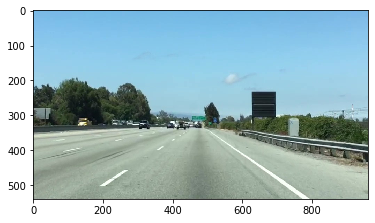

In [4]:
ysize= image.shape[0]
xsize= image.shape[1]
color_select=np.copy(image)
plt.imshow(image)


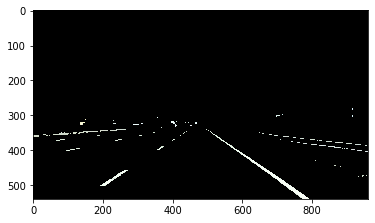

In [5]:
# define color selection criteria
# all pixels that meet my color criterion (those above the threshold) will be retained, 
# and those that do not (below the threshold) will be blacked out.
red_threshold=200
green_threshold=200
blue_threshold=200
rgb_threshold=[red_threshold,green_threshold,blue_threshold]

color_thresholds=(image[:,:,0]<rgb_threshold[0])\
                 |(image[:,:,1]<rgb_threshold[1])\
                 |(image[:,:,2]<rgb_threshold[2]) 
color_select[color_thresholds]=[0,0,0]
           
plt.imshow(color_select)
plt.show()


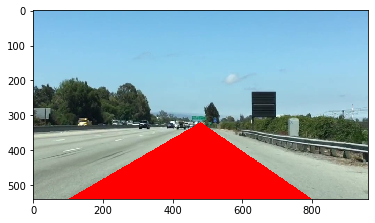

In [6]:
# Region Masking
# assume that the front facing camera that took the image is mounted in a fixed position 
#on the car, such that the lane lines will always appear in the same general region of 
#the image.Only consider pixels for color selection in the region where we expect to find 
#the lane lines. e.g. use triangular region/any polygon to mask everything else out

region_select = np.copy(image)

# Define a triangle region of interest 
# the origin (x=0, y=0) is in the upper left in image processing
left_bottom = [100,540]
right_bottom = [800,540]
apex = [480,320]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255, 0, 0]

# Display the image
plt.imshow(region_select)

([], <a list of 0 Text yticklabel objects>)

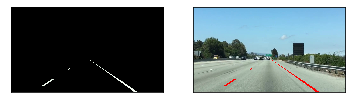

In [7]:
# Color Region. Combine two things we've done

color_select_after=np.copy(image)
color_select_after[color_thresholds| ~region_thresholds]=[0,0,0]

line_image=np.copy(image)
line_image[~color_thresholds& region_thresholds]=[255,0,0]


plt.figure()
plt.subplot(1,2,1)
plt.imshow(color_select_after)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(line_image)
plt.xticks([])
plt.yticks([])

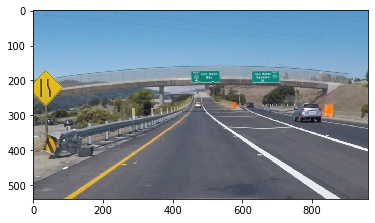

In [31]:
#lane lines are not always the same color, and even lines of the same color under different 
#lighting conditions (day, night, etc) may fail to be detected by our simple color selection.


# Canny to detect lane lines with opencv

#As far as a ratio of low_threshold to high_threshold, recommended: a low to high ratio of 1:2 or 1:3.

# cv2.Canny() actually applies Gaussian smoothing internally, but we can get a different result by
# applying further smoothing (and it's not a changeable parameter within cv2.Canny()!).

image2=mpimg.imread('canny.jpg')
plt.imshow(image2)



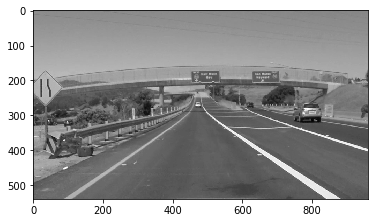

In [32]:
import cv2  #bringing in OpenCV libraries
gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

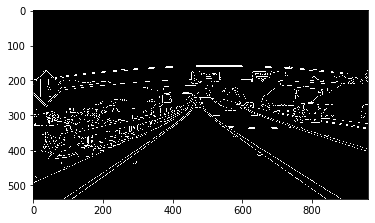

In [33]:
# Define a kernel size for Gaussian smoothing / blurring
# Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
kernel_size =5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

# Define parameters for Canny and run it
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')


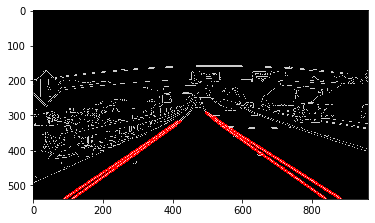

In [57]:
# Use Hough Transformation to detect edges in a region of interest.

# create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color) #black background and white polygon
masked_edges = cv2.bitwise_and(edges, mask)


rho=2  #distance resolution in pixels of the hough grid
theta=np.pi/180 #angular resolution in radians of the hough grid
threshold=25 #at least 25 points in image space need to be associated with each line segment.
min_line_length=42 #minimum number of pixels making up a line
max_line_gap=10 #maximum gap in pixels between connectable line segment
line_image=np.copy(image)*0  #creating a blank to draw lines on (black)

#run hough on edge detected image
#output "lines" is an array containing endpoints of detected line segments
lines=cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                      min_line_length,max_line_gap)

#iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),7)
        
#create a "color" binary image with 3 channels to combine with line image
color_edges=np.dstack((edges,edges,edges))


#draw the lines on the edge image
lines_edges=cv2.addWeighted(color_edges,0.8,line_image,1,0)
plt.imshow(lines_edges)